# Understanding college debt
I want to see what types of universities have students in debt.  We will be using the college scorecard API from data.gov.  I am interested in a number of variables, these are admissions rate, tuition, median household income, student size, etc.

It seems that the UC office of president <a href="http://www.ucop.edu/institutional-research-academic-planning/_files/College%20Scorecard%20Brief.pdf">claims that the UC schools are a good deal</a> based on data from the college scorecard.

You should go begin by getting an <a href="https://api.data.gov/signup/">API key for data.gov</a>.  There are many data.gov APIs that you can use this key for and they have fairly relaxed limits on the number of requests.

The documentation for the API can be found here...<br>
https://github.com/RTICWDT/open-data-maker/blob/master/API.md<br>
https://collegescorecard.ed.gov/data/

Let's import some packages.

In [2]:
from urllib2 import Request, urlopen
import requests, requests_cache
requests_cache.install_cache("cache")
import pandas as pd
import json
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Here are some variable names that we will be interested in.

In [3]:
varnames = """id
school.name
school.degrees_awarded.predominant
2014.admissions.admission_rate.overall
2014.cost.tuition.in_state
2014.cost.tuition.out_of_state
2014.aid.median_debt.completers.overall
2014.aid.median_debt.noncompleters
2005.student.demographics.median_hh_income
2005.student.demographics.poverty_rate
2014.aid.federal_loan_rate
2014.aid.pell_grant_rate
2014.student.size"""
fieldnames = varnames.split("\n")

__Exercise (1)__ I would like to make a complicated query from the API.  An example query from the API is 

<pre>https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.predominant=3&_fields=school.name,
2014.aid.pell_grant_rate&_sort=2014.student.size:desc&_page=1
&_per_page=100&api_key=YOURKEY
</pre>

Which can be parsed as  
1. the base url: https://api.data.gov/ed/collegescorecard/v1/schools.json, 
2. a filter of school.degrees_awarded.predominant=3, 
3. return the fields school.name,2014.aid.pell_grant_rate, 
4. sort by 2014.student.size in descending order, 
5. return 1 page of 100 entries, 
6. and use your api key

You can find a more complete description: https://github.com/RTICWDT/open-data-maker/blob/master/API.md

Fill in the following def that fits the following docstring, and gives the shown output.
<pre>
def query_url(key,fieldnames,filterstring,sortvar,numpages):
    """
    This takes all of the necessary parameters to form a query 
    to college scorecard
    Input: key (data.gov API key, string), fieldnames (list of variable 
      names), filterstring (string for filtering), sortvar (variable to 
      sort with by descending), numpages (number of pages to return)
    Output: url string
    """


query_url(key,fieldnames,'school.degrees_awarded.predominant=3',
  '2014.student.size',2)

https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.predominant=3&_fields=id,school.name,school.degrees_awarded.predominant,school.degree_urbanization,2014.admissions.admission_rate.overall,2014.cost.tuition.in_state,2014.cost.tuition.out_of_state,2014.aid.median_debt.completers.overall,2014.aid.median_debt.noncompleters,2005.student.demographics.median_hh_income,2005.student.demographics.poverty_rate,2014.aid.federal_loan_rate,2014.aid.pell_grant_rate,2014.student.size&_page=2&_per_page=100&_sort=2014.student.size:desc&api_key=YOURKEYHERE
</pre>

Try to reproduce the above behavior.

In [4]:
def query_url(key,fieldnames,condvar,condval,sortvar,numpage, verbose = False):#.return_request= False):
    """
    This takes all of the necessary parameters to form a query 
    to college scorecard
    Input: key (data.gov API key, string), fieldnames (list of variable 
      names), condvar string for filtering), condval (string for filtering), 
      sortvar (variable to sort with by descending), numpages (number of pages to return)
    Output: url string
    """
    urlbase = 'https://api.data.gov/ed/collegescorecard/v1/schools.json'
    par = {condvar: condval}
    par.update({
            "_fields": ",".join(fieldnames),
            "_page": numpage,
            "_per_page": 100,
            "_sort": sortvar+":desc",
            "api_key": key
        })
    if verbose:
        return 'error'
    param = urlbase,"?","&".join("{}={}".format(a,b) for a,b in par.items())
    #print ''.join(param)
    return requests.get(urlbase, params = par)
key = '0UR4Gr8ak8F9fi9TteVFhqRZTHFtdddWt3zYaOEN'
query_url(key,fieldnames, 'school.degrees_awarded.predominant', 3, '2014.student.size',2)

https://api.data.gov/ed/collegescorecard/v1/schools.json?school.degrees_awarded.predominant=3&_sort=2014.student.size:desc&_per_page=100&_fields=id,school.name,school.degrees_awarded.predominant,2014.admissions.admission_rate.overall,2014.cost.tuition.in_state,2014.cost.tuition.out_of_state,2014.aid.median_debt.completers.overall,2014.aid.median_debt.noncompleters,2005.student.demographics.median_hh_income,2005.student.demographics.poverty_rate,2014.aid.federal_loan_rate,2014.aid.pell_grant_rate,2014.student.size&api_key=0UR4Gr8ak8F9fi9TteVFhqRZTHFtdddWt3zYaOEN&_page=2


<Response [200]>

__Exercise (2)__ Make the query using Request and load the results into a DataFrame that makes sense.

In [259]:
def get_page(page):
    url = query_url(key,fieldnames,'school.degrees_awarded.predominant',3,'2014.student.size',2)
    url_json = url.json()
    df = pd.DataFrame(url_json['results'])
    return df

In [260]:
df = get_page(1)
df = df.append(get_page(2))
#df.columns
df = df.rename(columns = {
        u'2005.student.demographics.median_hh_income': 'income',
        u'2005.student.demographics.poverty_rate': 'poverty rate',
        u'2014.admissions.admission_rate.overall': 'admission rate',
        u'2014.aid.federal_loan_rate': 'loan rate',
        u'2014.aid.median_debt.completers.overall': 'debt completers',
        u'2014.aid.median_debt.noncompleters': 'debt non-completers', 
        u'2014.aid.pell_grant_rate': 'pell grant rate',
        u'2014.cost.tuition.in_state': 'I.S. tuition', u'2014.cost.tuition.out_of_state': 'O.F.S. tuition',
        u'2014.student.size': 'size', u'id': 'id', u'school.degrees_awarded.predominant': 'award',
        u'school.name': 'name'
    })
df.head()

,income,poverty rate,admission rate,loan rate,debt completers,debt non-completers,pell grant rate,I.S. tuition,O.F.S. tuition,size,id,award,name
0,21682.0,43.689999,NaN,0.3931,6789.5,3275.0,0.8644,5580,5580,12198,243346,3,Universidad Del Este
1,76546.0,6.540000,0.6201,0.5744,25000.0,10422.0,0.2884,12447,27400,12190,166513,3,University of Massachusetts-Lowell
2,48071.0,21.600000,0.3806,0.2225,11551.0,7000.0,0.5180,6389,13199,12175,190567,3,CUNY City College
3,43867.0,17.799999,0.6960,0.4002,18340.0,7624.0,0.4191,5950,19112,12171,188030,3,New Mexico State University-Main Campus
4,68463.0,9.010000,0.7077,0.5523,NaN,NaN,0.3857,11966,28390,12108,166638,3,University of Massachusetts-Boston


__Exercise (3)__ Produce scatterplots to demonstrate the associations between student debt (for 'completers') and median household income, pell grant rates, student poverty rate, tuition, and federal loan rate.  Do you have an explanation for the associations that you are seeing?  Are there some surprising associations.

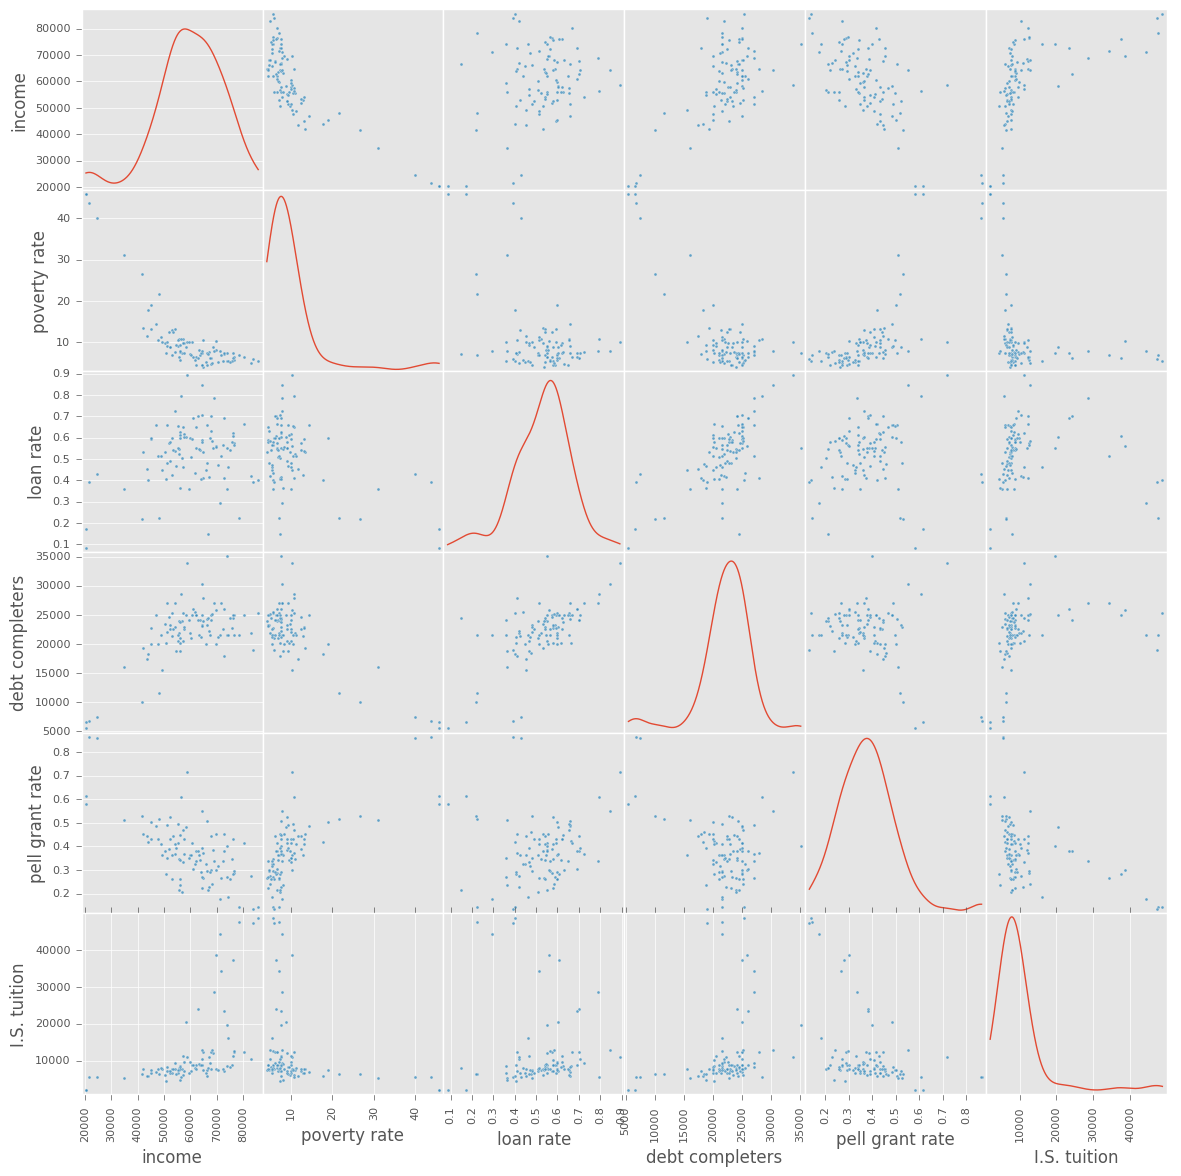

In [261]:
from pandas.tools.plotting import scatter_matrix
df.drop(['award','size','id','name','debt non-completers','admission rate','O.F.S. tuition'],inplace=True,axis=1,errors='ignore')
_ = scatter_matrix(df,figsize=(14,14),diagonal='kde')

There may be significance associations between poverty rate and income, income and pell grant rate, debt completers and income, and debt completers and loan rate. 

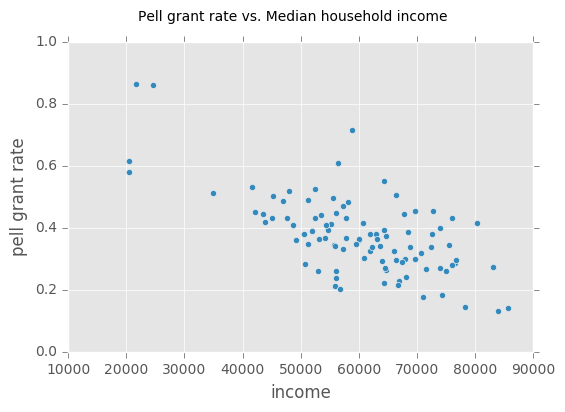

In [269]:
_ = df.plot('income','pell grant rate',kind = 'scatter')
_ = plt.suptitle('Pell grant rate vs. Median household income')

There seems to be a moderate negative correlation between the pell grant rate and income. Pell grant rate not only depends on income, but also depends on which college you are going to and other factors. Thus, there is a weak linear relationship between the two.

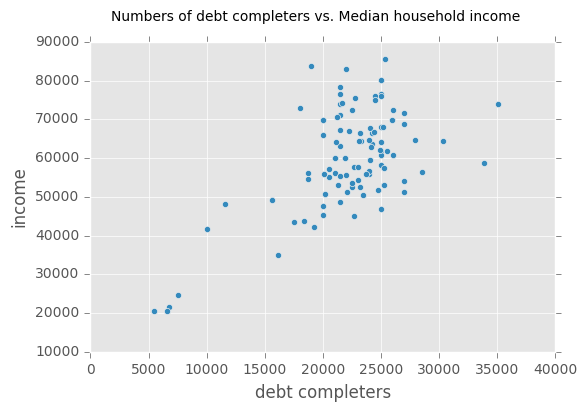

In [272]:
_ = df.plot('debt completers','income',kind = 'scatter')
_ = plt.suptitle('Numbers of debt completers vs. Median household income')

There may be a moderate positive correlation between the number of debt completers and income. As income increase, there are more debt completers which make sence because the more money you have in the family, the more money you can paid for your debt.

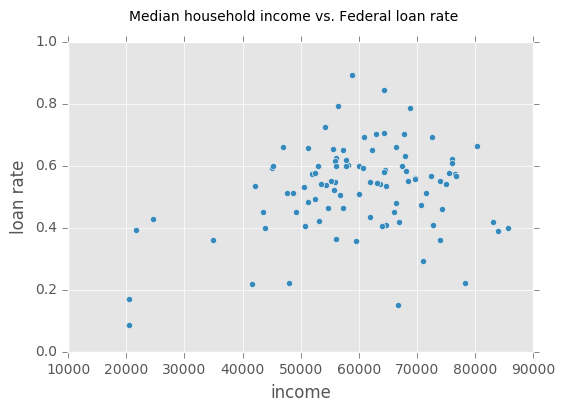

In [274]:
_ = df.plot('income','loan rate', kind='scatter')
_ = plt.suptitle('Median household income vs. Federal loan rate')

There seems to have a weak positive correlation between income and loan rate. People who have more income, loan more.

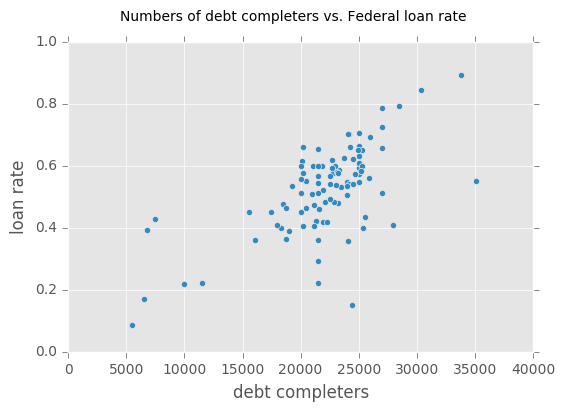

In [275]:
_ = df.plot('debt completers','loan rate', kind='scatter')
_ = plt.suptitle('Numbers of debt completers vs. Federal loan rate')

There is a strong positive correlation between the numbers of debt completers and loan rate. When loan rate increase, debt completers increases.

<h3>Conclusion:</h3>
<p>Income seems to have some relationships with every other factors. It is hard to explain the relationships between income and loan, and numbers of debt completers and Federal loan rate. For the relationship between income and loan, I expect people who have less income to loan more because they don't have enough money to pay their tuition. However, the scattered plot shows that people who earn more money will loan more. </p><p>
I expect that people who loan more money would have less number of debt completers, since they need more time and effort to pay their loans.</p>

<p>There are some possible explanations for the above situations:</p>
   1. higher income students tend to accept more debt, because they may have higher credit scores or they expect themselves to earn more in the future.
   2. higher income students tend to loan more, this might be because they know they have the abilities to complete their debts or they think loaning as an investment, since there is no interest rate, when one is still in college.
   3. the sample does not represents the population of universities, so there might be bias.